## Data Loading and Cleaning

In [4]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('S:/Projects/Chronic-Kidney-Disease-Prediction/data/kidney_disease.csv')

print(df.shape)
print(df.head())
print(df.dtypes)

# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

# Handle missing values (fill or drop)
df.fillna(df.median(numeric_only=True), inplace=True)

(400, 26)
   id   age    bp     sg   al   su     rbc        pc         pcc          ba  \
0   0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2   2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3   3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4   4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

   ...  pcv    wc   rc  htn   dm  cad appet   pe  ane classification  
0  ...   44  7800  5.2  yes  yes   no  good   no   no            ckd  
1  ...   38  6000  NaN   no   no   no  good   no   no            ckd  
2  ...   31  7500  NaN   no  yes   no  poor   no  yes            ckd  
3  ...   32  6700  3.9  yes   no   no  poor  yes  yes            ckd  
4  ...   35  7300  4.6   no   no   no  good   no   no            ckd  

[5 rows x 26 columns]
id                  int64
age               float64
bp      

In [11]:
# Replace tab characters only in object (string) columns
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.replace('\t', '', regex=False)

## Exploratory Data Analysis (EDA)

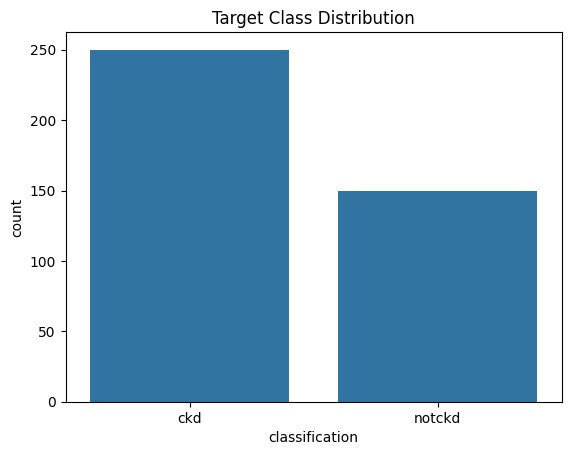

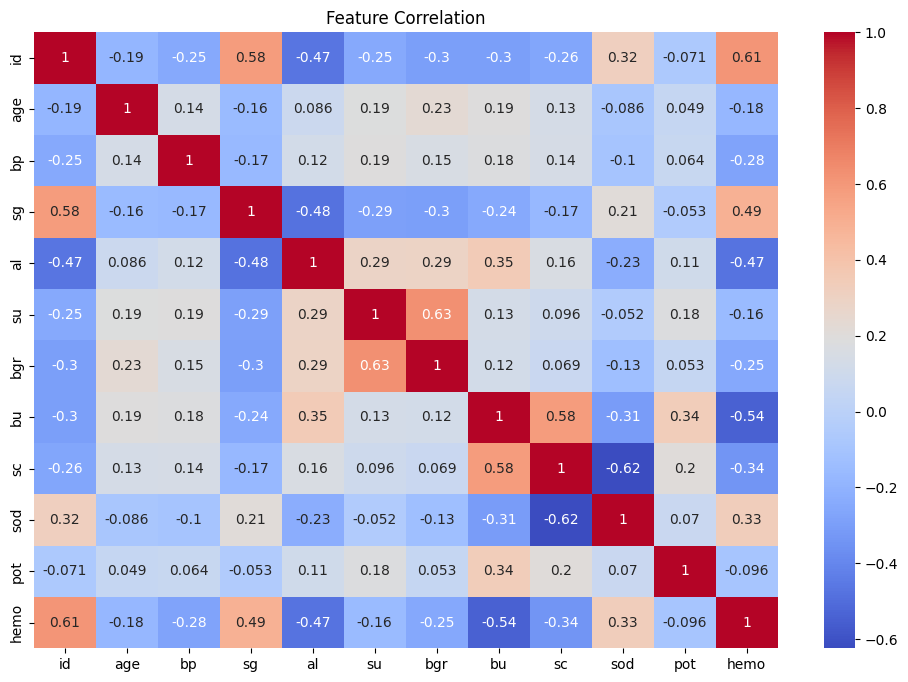

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Target variable
sns.countplot(x='classification', data=df)
plt.title("Target Class Distribution")
plt.show()

# Correlation matrix
corr = df.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

## Feature Engineering and Encoding

In [18]:
# Convert target to binary
df['target'] = df['classification'].apply(lambda x: 1 if x == 'ckd' else 0)

# Drop original target column
df.drop(columns=['classification'], inplace=True)

# Handle categorical features
df = pd.get_dummies(df, drop_first=True)

## Train-Test Split

In [21]:
from sklearn.model_selection import train_test_split

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training and Evaluation

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        52

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

ROC AUC Score: 1.0


In [41]:
# Convert all boolean columns to integers (0/1)
X_train = X_train.astype({col: int for col in X_train.select_dtypes(include='bool').columns})
X_test = X_test.astype({col: int for col in X_test.select_dtypes(include='bool').columns})

## Model Explainability with SHAP

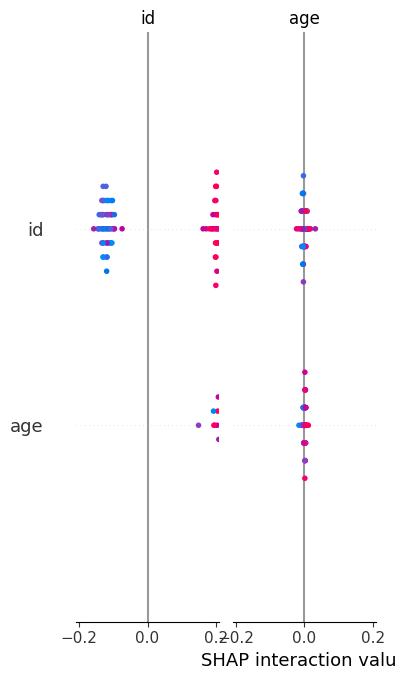

In [43]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test)

## CKD Predictions for PowerBI

In [45]:
df['prediction'] = model.predict(X)
df['probability'] = model.predict_proba(X)[:, 1]
df['patient_id'] = df.index
df.to_csv('ckd_predictions_for_powerbi.csv', index=False)